In [2]:
import numpy as np
import helpers_and_variables as hlp
import nlp as nlp_hlp
import ML_helpers as ml_hlp
import shap
import random
import pandas as pd
from sklearn import preprocessing

# import pixiedust
# %%pixie_debugger


In [3]:
"""
read the row data as pd data frame
"""
dataPath = "C:/Users/a7mad/Desktop/MEX/PekLung/PekLUng_20210503sav.xlsx"
password = None#
rawdataDF = hlp.get_exL_df(stringPath=dataPath, password=password, sheetNum=1)
rawdataDF = rawdataDF.iloc[1: , :]

""" 
read the data info as pd data frame
"""
dataInfoPath = "C:/Users/a7mad/Desktop/MEX/PekLung/Datainformation_minroAdjusted.xlsx"
dataInfoDF = hlp.get_cleaned_dataInfo_df(dataInfoPath)
katInfoDF = hlp.get_cleaned_katInfo_df(dataInfoPath)
"""
get dictionary of data information from data info data fram
"""
dict_of_katInfo = hlp.get_dict_of_katInfoDF(katInfoDF)
dict_of_dataInfo = hlp.get_dict_of_dataInfoDF(dataInfoDF)
""" 
Get the labels, under name Lungcancer_Num
check whether labels are 1=yes LC or 2=No LC and check STUDY_1 if valid, remove unlabeled and invalid patients

"""
rawdataDF, labels = hlp.get_labels_and_indices_unlabeled_patients(rawdataDF)

In [4]:
rawdataDF

,Patient,Age,Gender,STUDY_1,Diagnos2,Othercancer,Mutation_FULL,Stage_gr,DiagnosticInvestigation,PADdatum,...,EORTC_Q21_E,EORTC_Q22_E,EORTC_Q23_E,EORTC_Q24_E,EORTC_Q25_E,EORTC_Q26_E,EORTC_Q27_E,EORTC_Q28_E,EORTC_Q29_E,EORTC_Q30_E
1,1001.0,61.0,0.0,1.0,Ej cancer,None,0.0,-2146826288,None,None,...,2.0,4.0,2.0,2.0,1.0,1.0,2.0,2.0,6.0,7.0
2,1002.0,47.0,1.0,1.0,Kontroller,None,0.0,-2146826288,None,None,...,-2146826288,-2146826288,-2146826288,-2146826288,-2146826288,-2146826288,-2146826288,-2146826288,-2146826288,-2146826288
3,1003.0,66.0,1.0,1.0,Lungcancer,None,0.0,10.0,"Röntgenveriferad, punktion negativ",140904 (rtg),...,-2146826288,-2146826288,-2146826288,-2146826288,-2146826288,-2146826288,-2146826288,-2146826288,-2146826288,-2146826288
4,1004.0,68.0,1.0,1.0,ADCA (KRAS mut),None,2.0,40.0,EUS,141209,...,-2146826288,-2146826288,-2146826288,-2146826288,-2146826288,-2146826288,-2146826288,-2146826288,-2146826288,-2146826288
5,1008.0,87.0,1.0,1.0,Ej cancer,None,0.0,-2146826288,None,None,...,-2146826288,-2146826288,-2146826288,-2146826288,-2146826288,-2146826288,-2146826288,-2146826288,-2146826288,-2146826288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,4377.0,75.0,1.0,1.0,Ej klar -> kontroller,None,0.0,-2146826288,None,None,...,1.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,7.0,7.0
503,4378.0,55.0,0.0,1.0,Ej klar-> neuroendokrin tumör,neuroendokrin tumör,0.0,-2146826288,None,None,...,3.0,3.0,2.0,3.0,1.0,1.0,3.0,4.0,2.0,2.0
504,4380.0,45.0,0.0,1.0,Ej klar -> kontroller,None,0.0,-2146826288,None,None,...,4.0,4.0,3.0,3.0,2.0,3.0,3.0,3.0,1.0,1.0
505,4384.0,65.0,0.0,1.0,Ej klar -> kontroller,None,0.0,-2146826288,None,None,...,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,6.0,6.0


In [5]:
target = pd.DataFrame(data=labels, index=rawdataDF.index)
target.columns = ['Lungcancer_Num']
# 1 yes have LC, 0 No dont have LC 
target = target.Lungcancer_Num.apply(lambda x: 1 if x == 1 else -1)
labels = target

In [6]:
"""
Remove features, which includes information about the label inlucding Lungcancer_num, like diagnos2, aslo modules names
DiagnosticInvestigation (need to be discussed, since it includes dignostic which means non early prediction).
columns_tobe_removed=None --> predefind columns will be removed, see the function in helpers_and_variables file.
remove_cols_with_dates=True --> removes all columns with dates(this is relevance in case of tfidf), 
otherwise consider using converting dates to days, see function hlp.get_dates_in_days() in next cell.
"""
copy_rawdata =  hlp.get_dataframe_without_cols(rawdataDF, columns_tobe_removed=None, remove_cols_with_dates=True)
levitsky_rawdata = hlp.get_dataframe_with_specific_cols(rawdataDF)
# del rawdataDF
levitsky_rawdata

,Patient,Q9,Q5,Gender,Age,Q7e,Q7j,Q6,Br_5,Br_7,...,Fe_1,Fe_4,Fe_13,Sm_1,Sm_2,Sm_3,Oth_1,Oth_10,Oth_13,Oth_19
1,1001.0,2.0,5.0,0.0,61.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1002.0,4.0,3.0,1.0,47.0,1.0,1.0,3.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1003.0,5.0,5.0,1.0,66.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,1004.0,4.0,5.0,1.0,68.0,2.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
5,1008.0,4.0,5.0,1.0,87.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,4377.0,4.0,2.0,1.0,75.0,1.0,2.0,2.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
503,4378.0,5.0,2.0,0.0,55.0,1.0,2.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
504,4380.0,4.0,3.0,0.0,45.0,1.0,2.0,4.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
505,4384.0,2.0,4.0,0.0,65.0,1.0,1.0,3.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
cols_with_dates = hlp.get_cols_with_dates(rawdataDF)
test = pd.DataFrame.copy(rawdataDF[cols_with_dates])
test

In [ ]:
test = test[test != -2146826288]
test = test[test != '#NULL!']
# test = test.fillna(value='None' ,axis=1)
# test = test[test != 'None']
# test = test.dropna(axis=1)
test

In [ ]:
test = hlp.get_dates_in_days(test, automate_extract_cols_with_dates=False)

In [ ]:
test

In [ ]:
levitsky_rawdata_with_dates = pd.concat([levitsky_rawdata,test], axis=1)
levitsky_rawdata_with_dates

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(test)


### Preprocessing levitsky data in a binary manner (not nlp)

In [7]:
# normalizing the data
data = levitsky_rawdata.values
min_max = preprocessing.MinMaxScaler()
data_min_max = min_max.fit_transform(data)
# data_min_max
df = pd.DataFrame(data_min_max, columns=levitsky_rawdata.columns, index=levitsky_rawdata.index)
df['Patient'] = levitsky_rawdata['Patient']
levitsky_rawdata = df
del df, data_min_max, data, min_max
levitsky_rawdata

,Patient,Q9,Q5,Gender,Age,Q7e,Q7j,Q6,Br_5,Br_7,...,Fe_1,Fe_4,Fe_13,Sm_1,Sm_2,Sm_3,Oth_1,Oth_10,Oth_13,Oth_19
1,1001.0,0.25,0.8,0.0,0.514706,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1002.0,0.75,0.4,1.0,0.308824,0.0,0.0,0.50,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1003.0,1.00,0.8,1.0,0.588235,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,1004.0,0.75,0.8,1.0,0.617647,1.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
5,1008.0,0.75,0.8,1.0,0.897059,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,4377.0,0.75,0.2,1.0,0.720588,0.0,1.0,0.25,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
503,4378.0,1.00,0.2,0.0,0.426471,0.0,1.0,0.25,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
504,4380.0,0.75,0.4,0.0,0.279412,0.0,1.0,0.75,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
505,4384.0,0.25,0.6,0.0,0.573529,0.0,0.0,0.50,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### remove Id and separat 7 backround variables and 63 descriptors

In [8]:
# non nlp, remove patient Id
levitsky_rawdata = levitsky_rawdata.drop(columns=['Patient'], inplace=False)
backgroud_variables = levitsky_rawdata[levitsky_rawdata.columns[0:7]]
descriptors = levitsky_rawdata[levitsky_rawdata.columns[7:]]
levitsky_rawdata

,Q9,Q5,Gender,Age,Q7e,Q7j,Q6,Br_5,Br_7,Br_12,...,Fe_1,Fe_4,Fe_13,Sm_1,Sm_2,Sm_3,Oth_1,Oth_10,Oth_13,Oth_19
1,0.25,0.8,0.0,0.514706,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.75,0.4,1.0,0.308824,0.0,0.0,0.50,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.00,0.8,1.0,0.588235,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.75,0.8,1.0,0.617647,1.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
5,0.75,0.8,1.0,0.897059,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,0.75,0.2,1.0,0.720588,0.0,1.0,0.25,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
503,1.00,0.2,0.0,0.426471,0.0,1.0,0.25,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
504,0.75,0.4,0.0,0.279412,0.0,1.0,0.75,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
505,0.25,0.6,0.0,0.573529,0.0,0.0,0.50,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### make dict for nlp preprocessing

### Split data directly no need to vectorize (not nlp)

In [23]:
"""Split and shuffle"""
x_train, x_test, y_train, y_test = ml_hlp.get_train_test_split_data(levitsky_rawdata, labels, test_size=0.15,
                                                                            random_state=42, stratify = labels, shuffle = True)
# Self orginised map


In [24]:
"""
Get the training and testing vectorized objects as csr_matrix/ndarrays for quicker calcs
"""
X_train = ml_hlp.get_csr_matrix(x_train.values)
X_test = ml_hlp.get_csr_matrix(x_test.values)
Y_train = np.array(y_train, dtype='float')
Y_test = np.array(y_test, dtype='float')
# del X_train_vectorized, X_test_vectorized
"""
check the balance of labels
"""
unique_train = np.unique(Y_train, return_counts=True); unique_test = np.unique(Y_test, return_counts=True)
print("Training data, labels are: {0}  and prop.: {1}".format(unique_train[0], unique_train[1]/len(Y_train)))
print("Test data, labels are: {0}  and prop.: {1}".format(unique_test[0], unique_test[1]/len(Y_test)))

Training data, labels are: [-1.  1.]  and prop.: [0.38604651 0.61395349]
Test data, labels are: [-1.  1.]  and prop.: [0.38157895 0.61842105]


In [9]:
# levitsky_rawdata.to_csv('C:/Users/a7mad/Desktop/MEX/PekLung/levitsky_rawdata.csv')
# labels.to_csv('C:/Users/a7mad/Desktop/MEX/PekLung/levitsky_rawdata_labels.csv')

#### use all data

In [11]:
levitsky_train = ml_hlp.get_csr_matrix(levitsky_rawdata.values)
labels = np.array(labels, dtype='float')

"""
check the balance of labels
"""
unique_train = np.unique(labels, return_counts=True); 
print("Training data, labels are: {0}  and prop.: {1}".format(unique_train[0], unique_train[1]/len(labels)))

Training data, labels are: [-1.  1.]  and prop.: [0.38537549 0.61462451]


# SOM

In [105]:
from minisom import MiniSom  

# Initialization and training
som_shape = (2, 30)
som = MiniSom(som_shape[0], som_shape[1], levitsky_train.shape[1], sigma=1, learning_rate=1,
              neighborhood_function='gaussian', random_seed=10)

som.train_batch(levitsky_train[0:50], 5000, verbose=True)

 [  996 / 5000 ]  20% - 0:00:00 left 

 [ 2077 / 5000 ]  42% - 0:00:00 left 

 [ 3069 / 5000 ]  61% - 0:00:00 left 

 [ 4069 / 5000 ]  81% - 0:00:00 left 

 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 0.3742642717231924


In [106]:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in levitsky_train]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))# plotting the clusters using the first 2 dimentions of the data

for c in np.unique(cluster_index):
    plt.scatter(levitsky_train[cluster_index == c, 0],
                levitsky_train[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# plotting centroids
for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', 
                s=80, linewidths=35, color='k', label='centroid')
plt.legend();

In [109]:
def classify(som, data):
    """Classifies each sample in data in one of the classes definited
    using the method labels_map.
    Returns a list of the same length of data where the i-th element
    is the class assigned to data[i].
    """
    winmap = som.labels_map(X_train, y_train)
    default_class = np.sum(list(winmap.values())).most_common()[0][0]
    result = []
    for d in data:
        win_position = som.winner(d)
        if win_position in winmap:
            result.append(winmap[win_position].most_common()[0][0])
        else:
            result.append(default_class)
    return result

In [118]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(levitsky_train, labels, stratify=labels, test_size=0.25)

som = MiniSom(10, 40, 74, sigma=1, learning_rate=1, 
              neighborhood_function='triangle', random_seed=10)
som.pca_weights_init(X_train)
som.train_random(X_train, 500, verbose=False)

print(classification_report(y_test, classify(som, X_test)))


              precision    recall  f1-score   support

        -1.0       0.46      0.35      0.40        49
         1.0       0.64      0.74      0.69        78

    accuracy                           0.59       127
   macro avg       0.55      0.55      0.54       127
weighted avg       0.57      0.59      0.58       127



In [ ]:
import sys
sys.path.insert(0, '../')
%load_ext autoreload

from matplotlib.patches import Patch

from sklearn.preprocessing import minmax_scale, scale
%autoreload 2

In [172]:
# levitsky_rawdata = pd.DataFrame(data=levitsky_train, columns=feature_names)
levitsky_rawdata.insert(0, "label", labels)
levitsky_rawdata

,label,Q9,Q5,Gender,Age,Q7e,Q7j,Q6,Br_5,Br_7,...,Fe_1,Fe_4,Fe_13,Sm_1,Sm_2,Sm_3,Oth_1,Oth_10,Oth_13,Oth_19
0,-1.0,0.25,0.8,0.0,0.514706,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.0,0.75,0.4,1.0,0.308824,0.0,0.0,0.50,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,1.00,0.8,1.0,0.588235,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,1.0,0.75,0.8,1.0,0.617647,1.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
4,-1.0,0.75,0.8,1.0,0.897059,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,-1.0,0.75,0.2,1.0,0.720588,0.0,1.0,0.25,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
502,1.0,1.00,0.2,0.0,0.426471,0.0,1.0,0.25,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
503,-1.0,0.75,0.4,0.0,0.279412,0.0,1.0,0.75,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
504,-1.0,0.25,0.6,0.0,0.573529,0.0,0.0,0.50,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [173]:
feature_names = levitsky_rawdata.columns

X = levitsky_rawdata[feature_names].values

feature_df = levitsky_rawdata
target = feature_df.iloc[:,0]
Features = feature_df.iloc[:,1:]


In [ ]:
import seaborn as sn
plt.figure(figsize=(30,30))

feat_num = len(feature_names)

# plt.figure(figsize=(feat_num,feat_num/2))
corrMatrix = feature_df.corr().round(2)
sn.heatmap(corrMatrix, annot=True)

# plt.tight_layout()
plt.show()

[0.05280818 0.01996837 0.04820899 0.19320359 0.00924753 0.01033927
 0.02666477 0.01639426 0.00370894 0.01886054 0.00686332 0.01112485
 0.0120901  0.00746536 0.00711106 0.00417182 0.01290127 0.
 0.         0.00874096 0.         0.01326939 0.00799599 0.0201699
 0.03349755 0.00158926 0.01756093 0.00476779 0.         0.00623479
 0.01156279 0.01694044 0.         0.         0.0106878  0.
 0.01315852 0.         0.01039556 0.         0.00626111 0.
 0.         0.         0.         0.         0.00625773 0.
 0.         0.00614395 0.00444994 0.         0.01084673 0.02175886
 0.         0.02707447 0.00556243 0.00508565 0.01750315 0.
 0.01039975 0.00102784 0.00647167 0.01554408 0.00651973 0.03833907
 0.03138346 0.02066375 0.00550205 0.0084827  0.01128378 0.03190143
 0.02251059 0.04132219]


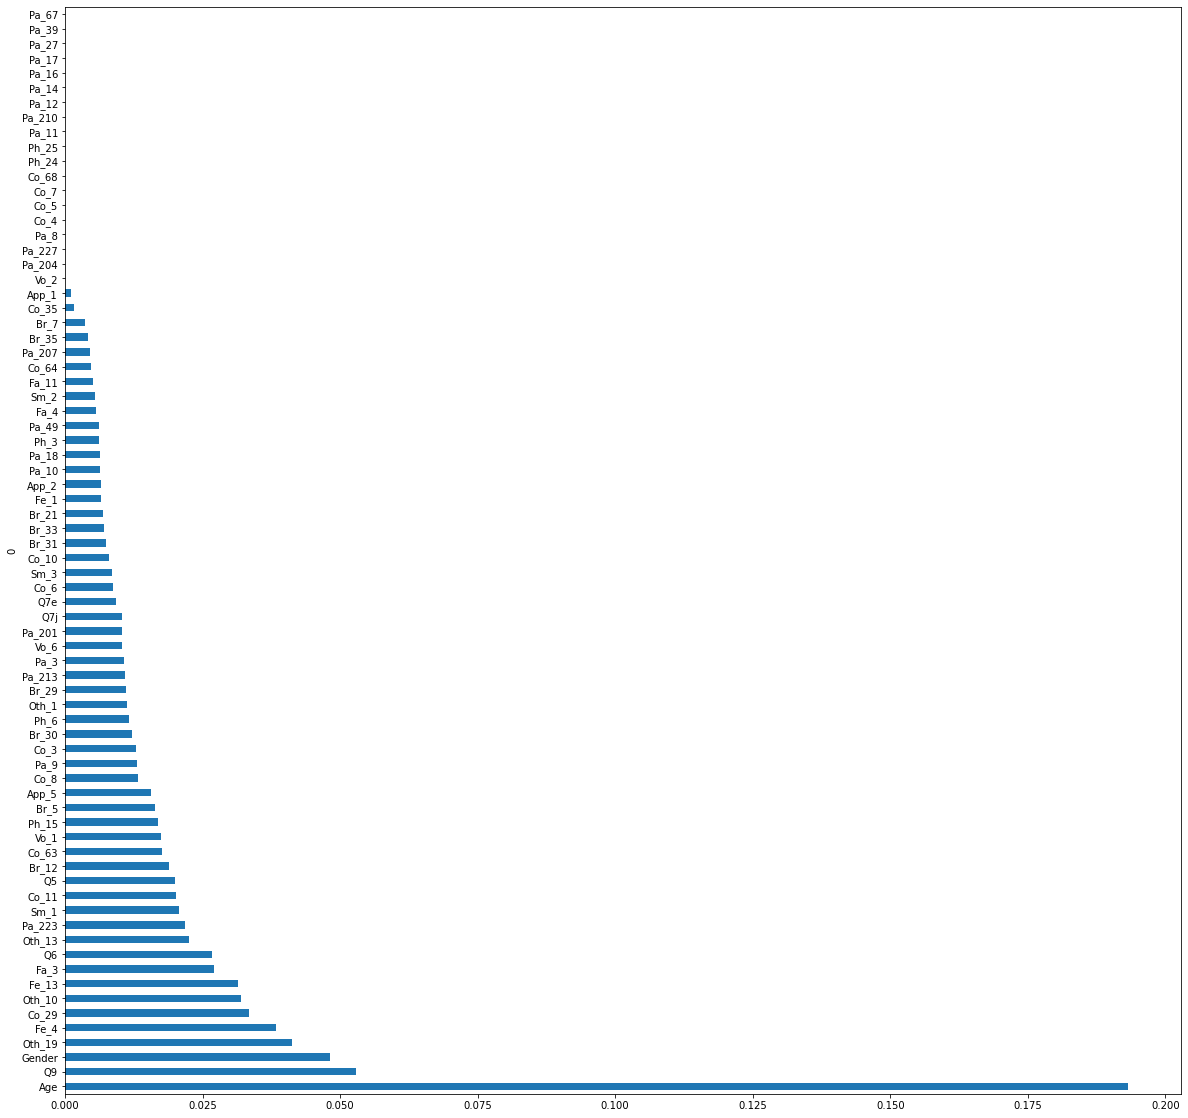

In [179]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
# dt = DecisionTreeClassifier(random_state = 42, class_weight = "balanced")


plt.figure(figsize=(20,20))
model = DecisionTreeRegressor(random_state=0)
model.fit(Features, target)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
# #plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=Features.columns)
feat_importances.nlargest(Features.shape[1]).plot(kind='barh')
plt.show()

In [211]:
size = 40
som = MiniSom(size, size, len(X[0]),
              neighborhood_function='gaussian', sigma=1.5, learning_rate=3,
              random_seed=1)

som.pca_weights_init(X)
som.train_random(X, 1500, verbose=1)

 [  251 / 1500 ]  17% - 0:00:00 left 

 [  567 / 1500 ]  38% - 0:00:00 left 

 [  859 / 1500 ]  57% - 0:00:00 left 

 [ 1140 / 1500 ]  76% - 0:00:00 left 

 [ 1423 / 1500 ]  95% - 0:00:00 left 

 [ 1500 / 1500 ] 100% - 0:00:00 left 
 quantization error: 0.4440741453705956


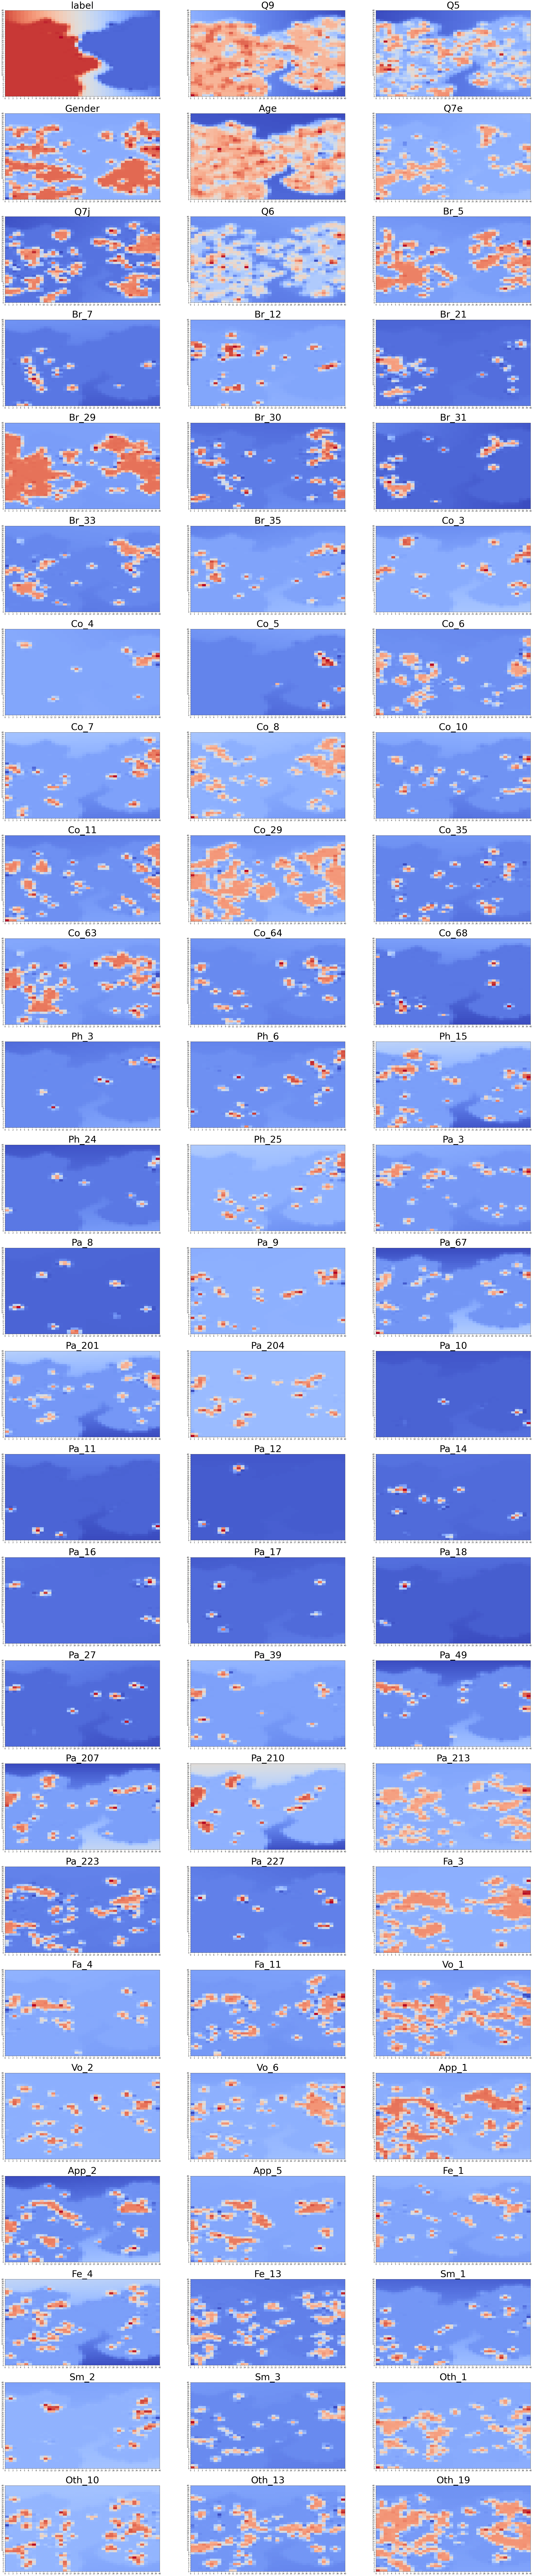

In [212]:
W = som.get_weights()
plt.figure(figsize=(50, 250))
for i, f in enumerate(feature_names):
    plt.subplot(25, 3, i+1)
    plt.title(f,fontdict={'fontsize': 50})
    plt.pcolor(W[:,:,i].T, cmap='coolwarm')
    plt.xticks(np.arange(size+1))
    plt.yticks(np.arange(size+1))
# plt.tight_layout()
plt.show()

In [213]:
def som_feature_selection(W, labels, target_index = 0, a = 0.04):
    """ Performs feature selection based on a self organised map trained with the desired variables

    INPUTS: W = numpy array, the weights of the map (X*Y*N) where X = map's rows, Y = map's columns, N = number of variables
            labels = list, holds the names of the variables in same order as in W
            target_index = int, the position of the target variable in W and labels
            a = float, an arbitary parameter in which the selection depends, values between 0.03 and 0.06 work well

    OUTPUTS: selected_labels = list of strings, holds the names of the selected features in order of selection
             target_name = string, the name of the target variable so that user is sure he gave the correct input
    """


    W_2d = np.reshape(W, (W.shape[0]*W.shape[1], W.shape[2])) #reshapes W into MxN assuming M neurons and N features
    target_name = labels[target_index]


    Rand_feat = np.random.uniform(low=0, high=1, size=(W_2d.shape[0], W_2d.shape[1] - 1)) # create N -1 random features
    W_with_rand = np.concatenate((W_2d,Rand_feat), axis=1) # add them to the N regular ones
    W_normed = (W_with_rand - W_with_rand.min(0)) / W_with_rand.ptp(0) # normalize each feature between 0 and 1

    Target_feat = W_normed[:,target_index] # column of target feature

    # Two conditions to check against a
    Check_matrix1 = abs(np.vstack(Target_feat) - W_normed)
    Check_matrix2 = abs(np.vstack(Target_feat) + W_normed - 1)
    S = np.logical_or(Check_matrix1 <= a, Check_matrix2 <= a).astype(int) # applie "or" element-wise in two matrices

    S[:,target_index] = 0 #ignore the target feature so that it is not picked

    selected_labels = []
    while True:

        S2 = np.sum(S, axis=0) # add all rows for each column (feature)

        if not np.any(S2 > 0): # if all features add to 0 kill
            break

        selected_feature_index = np.argmax(S2) # feature with the highest sum gets selected first

        if selected_feature_index > (S.shape[1] - (Rand_feat.shape[1] + 1)): # if random feature is selected kill
            break


        selected_labels.append(labels[selected_feature_index])

        # delete all rows where selected feature evaluates to 1, thus avoid selecting complementary features
        rows_to_delete = np.where(S[:,selected_feature_index] == 1)
        S[rows_to_delete, :] = 0

#     selected_labels = [label for i, label in enumerate(labels) if i in feature_indeces]
    return selected_labels, target_name

In [221]:
selected_features, target_name = som_feature_selection(W, feature_names, 0, 0.06)
print("Target variable: {}\nSelected features {}".format(target_name, selected_features))

Target variable: label
Selected features ['Pa_11', 'Co_10', 'Pa_210']


In [166]:
# labels

In [81]:
from sklearn_som.som import SOM
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


In [85]:
som = SOM(m=10, n=30, dim=74)
som.fit(levitsky_train)

In [86]:
predictions = som.predict(levitsky_train)

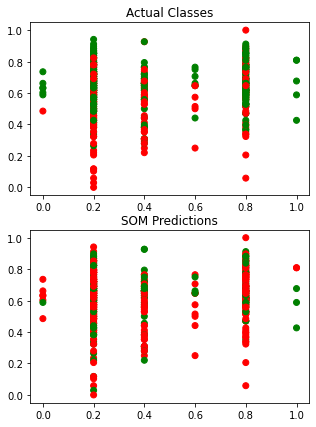

In [87]:
# Plot the results
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(5,7))
x = levitsky_train[:,1]
y = levitsky_train[:,3]
colors = ['red', 'green']

ax[0].scatter(x, y, c=labels, cmap=ListedColormap(colors))

ax[0].title.set_text('Actual Classes')
ax[1].scatter(x, y, c=predictions, cmap=ListedColormap(colors))
ax[1].title.set_text('SOM Predictions')
# plt.savefig('iris_example.png')
plt.show()

In [30]:
display(levitsky_rawdata)

,Q9,Q5,Gender,Age,Q7e,Q7j,Q6,Br_5,Br_7,Br_12,...,Fe_1,Fe_4,Fe_13,Sm_1,Sm_2,Sm_3,Oth_1,Oth_10,Oth_13,Oth_19
1,0.25,0.8,0.0,0.514706,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.75,0.4,1.0,0.308824,0.0,0.0,0.50,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.00,0.8,1.0,0.588235,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.75,0.8,1.0,0.617647,1.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
5,0.75,0.8,1.0,0.897059,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,0.75,0.2,1.0,0.720588,0.0,1.0,0.25,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
503,1.00,0.2,0.0,0.426471,0.0,1.0,0.25,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
504,0.75,0.4,0.0,0.279412,0.0,1.0,0.75,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
505,0.25,0.6,0.0,0.573529,0.0,0.0,0.50,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
